<a href="https://colab.research.google.com/github/xphoenixx32/test_query/blob/main/%5Binternal_shared%5D_monthly_sharing_ls_sessions_learning_curve_20240329.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import pkgs**

In [ ]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import seaborn as sns

from statsmodels.formula.api import ols
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# from ydata_profiling import ProfileReport
from google.colab import drive
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
# !pip install ydata_profiling

## **1. Setting Connection to Drive**

In [ ]:
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/01 file_share_to_google_colab'
os.chdir(folder_path)

file_list = os.listdir(folder_path)
for file_name in file_list:
    if '.ipynb' in file_name:
        continue
    else:
        print(file_name)

Mounted at /content/drive
Temp Query 1_20240229-153741.csv
orders_feature_imp.dot
Temp Query 2_20240311-111404.csv
Temp Query 2_20240311-132154.csv


In [ ]:
%%time
import_df = pd.read_csv('/content/drive/MyDrive/01 file_share_to_google_colab/Temp Query 2_20240311-132154.csv')

CPU times: user 1.29 s, sys: 252 ms, total: 1.54 s
Wall time: 2.36 s


## **2. Data Preprocessing**

In [ ]:
%%time
df = import_df.copy()

CPU times: user 23.8 ms, sys: 28 ms, total: 51.7 ms
Wall time: 270 ms


In [ ]:
%%time
# time-related category
df['grass_month'] = pd.to_datetime(df['grass_month'])

df['ls_year'] = df['grass_month'].dt.year
df['ls_month'] = df['grass_month'].dt.month
df['ls_year_month'] = df['ls_year'].astype('str') + \
                      '-' + \
                      df['ls_month'].astype('str').apply(lambda x: '0' + x if len(x) == 1 else x)

df['min_streaming_month'] = pd.to_datetime(df['min_streaming_month'])

df['start_ls_year'] = df['min_streaming_month'].dt.year
df['start_ls_month'] = df['min_streaming_month'].dt.month
df['start_ls_year_month'] = df['start_ls_year'].astype('str') + \
                            '-' + \
                            df['start_ls_month'].astype('str').apply(lambda x: '0' + x if len(x) == 1 else x)

df['ls_gap_months_from_start'] = (df['ls_year'] - df['start_ls_year'])*12 + (df['ls_month'] - df['start_ls_month'])

CPU times: user 1.37 s, sys: 15 ms, total: 1.38 s
Wall time: 2.05 s


In [ ]:
%%time
# reward metrics
df['cv_reward'] = df['pv_coin_voucher_rebate_by_shopee'] + df['pv_coin_voucher_rebate_by_seller'] + \
                  df['sv_coin_voucher_rebate_by_shopee'] + df['sv_coin_voucher_rebate_by_seller']

df['dv_reward'] = df['pv_discount_voucher_rebate_by_shopee'] + df['pv_discount_voucher_rebate_by_seller'] + \
                  df['sv_discount_voucher_rebate_by_shopee'] + df['sv_discount_voucher_rebate_by_seller']

df['fsv_reward'] = df['fsv_shipping_rebate_by_shopee'] + df['fsv_shipping_rebate_by_seller']

CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 18.8 ms


In [ ]:
%%time
# align the 'int64' format
df.fillna(0, inplace = True)
df['viewer_cnt'] = np.around(df['viewer_cnt']).astype(np.int64)
df['buyer_cnt'] = np.around(df['buyer_cnt']).astype(np.int64)
df['gmv'] = np.around(df['gmv']).astype(np.int64)
df['orders'] = np.around(df['orders']).astype(np.int64)

df['gmv_per_order'] = df['gmv'] / df['orders']

df = df.groupby('streamer_id',
                as_index = False).apply(lambda x: x.sort_values('accum_sessions'))

# orders(per session) = viewer_cnt * buyers/viewers(CVR) * orders/buyers
df['conversion_rate'] = df['buyer_cnt'] / df['viewer_cnt']
df['orders_per_buyer'] = df['orders'] / df['buyer_cnt']

# CUMSUM related metrics
df['cum_orders'] = df.groupby('streamer_id')['orders'].transform(lambda x: x.cumsum())
df['cum_gmv'] = df.groupby('streamer_id')['gmv'].transform(lambda x: x.cumsum())
df['cum_viewer_cnt'] = df.groupby('streamer_id')['viewer_cnt'].transform(lambda x: x.cumsum())
df['cum_buyer_cnt'] = df.groupby('streamer_id')['buyer_cnt'].transform(lambda x: x.cumsum())

# calaulating on rate/ratio
df['cum_conversion_rate'] = df['cum_buyer_cnt'] / df['cum_viewer_cnt']
df['cum_orders_per_cum_buyers'] = df['cum_orders'] / df['cum_buyer_cnt']
df['cum_gmv_per_cum_order'] = df['cum_gmv'] / df['cum_orders']
df['cum_orders_per_accum_session'] = df['cum_orders'] / df['accum_sessions']
df['cum_gmv_per_accum_session'] = df['cum_gmv'] / df['accum_sessions']
df['cum_viewers_per_accum_session'] = df['cum_viewer_cnt'] / df['accum_sessions']

df['discount_rate'] = np.around(((df['accum_list_price'] - df['sold_price']) / df['accum_list_price']), 3)

CPU times: user 34 s, sys: 551 ms, total: 34.6 s
Wall time: 39.8 s


In [ ]:
%%time
df = df.fillna(0)
# df['gmv'] = df.apply(lambda x: 0 if x['orders'] == 0 else x['gmv'], axis = 1)
df = df.reset_index(drop = True)
df

CPU times: user 810 ms, sys: 221 ms, total: 1.03 s
Wall time: 1.99 s


,grass_month,week_day,grass_hour,streamer_type,shop_category,ls_session_id,streamer_id,age_range,gender,min_streaming_month,...,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,cum_conversion_rate,cum_orders_per_cum_buyers,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session,discount_rate
0,2023-02-01,3,14,Other C2C (non-MS),Home & Living,2708583,12278,45+,Female,2023-02-01,...,0,50,0,0.0,0.0,0.0,0.0,0.0,50.000000,0.0
1,2023-02-01,3,16,Other C2C (non-MS),Home & Living,2708665,12278,45+,Female,2023-02-01,...,0,59,0,0.0,0.0,0.0,0.0,0.0,29.500000,0.0
2,2023-10-01,4,16,Other C2C (non-MS),Mother & Baby,3259446,22036,35_44,Female,2023-10-01,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,2023-10-01,4,16,Other C2C (non-MS),Mother & Baby,3301925,22036,35_44,Female,2023-10-01,...,0,1,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0
4,2023-10-01,4,22,Other C2C (non-MS),Mother & Baby,3302872,22036,35_44,Female,2023-10-01,...,0,4,0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241850,2023-12-01,1,18,Other C2C (non-MS),Life & Entertainment,3534178,1150399673,Others,Others,2023-12-01,...,0,93,0,0.0,0.0,0.0,0.0,0.0,31.000000,0.0
241851,2023-12-01,2,10,Other C2C (non-MS),Life & Entertainment,3535671,1150399673,Others,Others,2023-12-01,...,0,111,0,0.0,0.0,0.0,0.0,0.0,27.750000,0.0
241852,2023-12-01,2,16,Other C2C (non-MS),Life & Entertainment,3536504,1150399673,Others,Others,2023-12-01,...,0,238,0,0.0,0.0,0.0,0.0,0.0,47.600000,0.0
241853,2023-12-01,3,9,Other C2C (non-MS),Life & Entertainment,3538060,1150399673,Others,Others,2023-12-01,...,0,349,0,0.0,0.0,0.0,0.0,0.0,58.166667,0.0


In [ ]:
pd.set_option('display.max_rows', 80)

df.dtypes

grass_month                             datetime64[ns]
week_day                                         int64
grass_hour                                       int64
streamer_type                                   object
shop_category                                   object
ls_session_id                                    int64
streamer_id                                      int64
age_range                                       object
gender                                          object
min_streaming_month                     datetime64[ns]
accum_sessions                                   int64
orders                                           int64
gmv                                              int64
buyer_cnt                                        int64
sold_price                                     float64
accum_list_price                               float64
pv_discount_voucher_rebate_by_shopee           float64
pv_discount_voucher_rebate_by_seller           float64
pv_coin_vo

In [ ]:
# validation for cumsum() function
id_lst = df['streamer_id'].unique().tolist()
rs_id_lst = random.sample(id_lst, 5)

for i in rs_id_lst:
    print('streamer_id : ', str(i))
    df[df['streamer_id'] == i].sort_values('accum_sessions')[['grass_month',
                                                              'accum_sessions',
                                                              'orders',
                                                              'cum_orders',
                                                              'gmv',
                                                              'cum_gmv',
                                                              'cum_viewer_cnt',
                                                              'cum_buyer_cnt',
                                                              'conversion_rate',
                                                              'cum_conversion_rate',
                                                              'cum_gmv_per_cum_order',
                                                              'cum_orders_per_accum_session',
                                                              'cum_gmv_per_accum_session',
                                                              'cum_viewers_per_accum_session']].head(5)
    print('-' * 200)

streamer_id :  223791610


,grass_month,accum_sessions,orders,cum_orders,gmv,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,conversion_rate,cum_conversion_rate,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session
104024,2023-02-01,1,0,0,0,0,38,0,0.0,0.0,0.0,0.0,0.0,38.0
104025,2023-02-01,2,0,0,0,0,259,0,0.0,0.0,0.0,0.0,0.0,129.5


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
streamer_id :  771337184


,grass_month,accum_sessions,orders,cum_orders,gmv,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,conversion_rate,cum_conversion_rate,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session
136042,2023-01-01,1,1,1,145,145,863,1,0.001159,0.001159,145.0,1.000000,145.000000,863.00
136043,2023-01-01,2,0,1,0,145,1056,1,0.000000,0.000947,145.0,0.500000,72.500000,528.00
136044,2023-01-01,3,0,1,0,145,1125,1,0.000000,0.000889,145.0,0.333333,48.333333,375.00
136045,2023-01-01,4,0,1,0,145,1183,1,0.000000,0.000845,145.0,0.250000,36.250000,295.75
136046,2023-02-01,5,0,1,0,145,1367,1,0.000000,0.000732,145.0,0.200000,29.000000,273.40


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
streamer_id :  1068032674


,grass_month,accum_sessions,orders,cum_orders,gmv,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,conversion_rate,cum_conversion_rate,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session
229823,2023-10-01,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000
229824,2023-10-01,2,0,0,0,0,5,0,0.0,0.0,0.0,0.0,0.0,2.500000
229825,2023-10-01,3,0,0,0,0,7,0,0.0,0.0,0.0,0.0,0.0,2.333333
229826,2023-10-01,4,0,0,0,0,7,0,0.0,0.0,0.0,0.0,0.0,1.750000
229827,2023-10-01,5,0,0,0,0,16,0,0.0,0.0,0.0,0.0,0.0,3.200000


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
streamer_id :  886375077


,grass_month,accum_sessions,orders,cum_orders,gmv,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,conversion_rate,cum_conversion_rate,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session
148950,2023-04-01,1,0,0,0,0,9,0,0.0,0.0,0.0,0.0,0.0,9.0
148951,2023-04-01,2,0,0,0,0,44,0,0.0,0.0,0.0,0.0,0.0,22.0


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
streamer_id :  166846646


,grass_month,accum_sessions,orders,cum_orders,gmv,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,conversion_rate,cum_conversion_rate,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session
98167,2023-07-01,1,0,0,0,0,435,0,0.0,0.0,0.0,0.0,0.0,435.0
98168,2023-07-01,2,0,0,0,0,435,0,0.0,0.0,0.0,0.0,0.0,217.5
98169,2023-07-01,3,0,0,0,0,585,0,0.0,0.0,0.0,0.0,0.0,195.0
98170,2023-07-01,4,0,0,0,0,612,0,0.0,0.0,0.0,0.0,0.0,153.0
98171,2023-07-01,5,0,0,0,0,615,0,0.0,0.0,0.0,0.0,0.0,123.0


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### **2-1. Streamer Distribution**

In [ ]:
demo_col = ['shop_category', 'age_range', 'gender', 'start_ls_year_month', 'week_day', 'grass_hour']

for i in demo_col:
    df.pivot_table(index = 'streamer_type',
                   columns = i,
                   values = 'streamer_id',
                   aggfunc = 'nunique',
                   margins = True,
                   fill_value = 0).T
    print('-'*150)

streamer_type,Other C2C (Affiliates),Other C2C (MS),Other C2C (non-MS),Other malls,All
shop_category,,,,,
Beauty,27,2,640,29,698
Books,3,0,112,2,117
Everything Else,3,0,47,0,50
Food & Beverages,13,9,439,30,491
Game Kingdom,4,3,39,2,48
Hardware & 3C,5,2,115,10,132
Health,7,7,179,19,212
Home & Living,33,18,1332,38,1421
Home Electronic,4,5,99,16,124


------------------------------------------------------------------------------------------------------------------------------------------------------


streamer_type,Other C2C (Affiliates),Other C2C (MS),Other C2C (non-MS),Other malls,All
age_range,,,,,
25_34,134,74,2892,69,3169
35_44,51,37,1527,22,1637
45+,24,41,1070,89,1224
Below 24,39,12,1132,32,1215
Others,25,16,2973,27,3041
All,273,180,9594,239,10286


------------------------------------------------------------------------------------------------------------------------------------------------------


streamer_type,Other C2C (Affiliates),Other C2C (MS),Other C2C (non-MS),Other malls,All
gender,,,,,
Female,195,104,5349,139,5787
Male,69,76,2027,97,2269
Others,9,0,2218,3,2230
All,273,180,9594,239,10286


------------------------------------------------------------------------------------------------------------------------------------------------------


streamer_type,Other C2C (Affiliates),Other C2C (MS),Other C2C (non-MS),Other malls,All
start_ls_year_month,,,,,
2023-01,8,6,539,23,576
2023-02,12,11,669,15,707
2023-03,21,20,980,33,1054
2023-04,18,9,1006,18,1051
2023-05,22,21,829,32,904
2023-06,15,13,761,14,803
2023-07,21,20,786,13,840
2023-08,16,13,839,21,889
2023-09,21,22,754,14,811


------------------------------------------------------------------------------------------------------------------------------------------------------


streamer_type,Other C2C (Affiliates),Other C2C (MS),Other C2C (non-MS),Other malls,All
week_day,,,,,
1,132,101,4267,84,4584
2,150,111,4496,122,4879
3,155,134,4642,130,5061
4,136,121,4458,123,4838
5,145,127,4581,121,4974
6,137,95,4304,65,4601
7,119,72,3875,55,4121
All,273,180,9594,239,10286


------------------------------------------------------------------------------------------------------------------------------------------------------


streamer_type,Other C2C (Affiliates),Other C2C (MS),Other C2C (non-MS),Other malls,All
grass_hour,,,,,
0,63,35,1903,9,2010
1,35,23,1382,3,1443
2,17,14,989,2,1022
3,11,8,707,1,727
4,13,5,548,0,566
5,4,6,480,0,490
6,7,10,533,0,550
7,11,13,648,3,675
8,20,17,983,1,1021


------------------------------------------------------------------------------------------------------------------------------------------------------


# **3. EDA Plot & Learning Curve**

## **3-1. Displot on accum_sessions**

In [ ]:
InteractiveShell.ast_node_interactivity = 'last'

In [ ]:
def displot_on_streamer_counts_per_accum_sessions(in_top_ls_months):
    lst = []

    for i in range(0, in_top_ls_months):
        lst.append(i)

    dis_df = df.loc[df['ls_gap_months_from_start'].isin(lst)].groupby('streamer_id')['accum_sessions'].count().to_frame().reset_index()
    fig = px.histogram(dis_df,
                      x = 'accum_sessions',
                      marginal = 'box')
    fig.update_layout(
        xaxis_title = "Streamer Count",
        yaxis_title = "Accumulated Sessions",
        title = f"Distribution Plot of Streamer Count of each Accumulated Sessions in the {in_top_ls_months} Start-LS Months"
    )
    fig.show()
    dis_df['accum_sessions'].describe([.25, .8, .85, .9, .95, .99])

In [ ]:
displot_on_streamer_counts_per_accum_sessions(3)

## **3-2. Plotting by Type**

### 3-2-1. EDA Plot

In [ ]:
InteractiveShell.ast_node_interactivity = 'last'

In [ ]:
target_sessions = 50

plot_df = df.groupby(['streamer_type', 'accum_sessions'])['cum_orders_per_accum_session'].mean().to_frame('avg_cum_orders_per_accum_session').reset_index()
plot_df = plot_df.loc[plot_df['accum_sessions'] <= target_sessions]

fig = px.line(x = plot_df['accum_sessions'],
              y = plot_df['avg_cum_orders_per_accum_session'],
              color = plot_df['streamer_type'])

fig.update_layout(
    xaxis_title = "Accumulated Sessions",
    yaxis_title = "Mean of Cumulative Orders per Accumulated Sessions",
    title = f"Cumulative Orders per Accumulated Sessions of Head {target_sessions} LS sessions of Every Streamers"
)

fig.show()

In [ ]:
least_ls_sessions = 100

filter_condition = df.groupby(['streamer_id'])['accum_sessions'].count().to_frame('sessions_count').reset_index()
filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].tolist()

filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & df['streamer_id'].isin(filter_user)]

plot_df = filter_df.groupby(['streamer_type', 'accum_sessions'])['cum_orders_per_accum_session'].mean().to_frame('avg_cum_orders_per_accum_session').reset_index()

fig = px.line(x = plot_df['accum_sessions'],
              y = plot_df['avg_cum_orders_per_accum_session'],
              color = plot_df['streamer_type'])

fig.update_layout(
    xaxis_title = "Accumulated Sessions",
    yaxis_title = "Mean of Cumulative Orders per Accumulated Sessions",
    title = f"Cumulative Orders per Accumulated Sessions of Head {least_ls_sessions} LS sessions",
    annotations = [
        dict(
            x = 0.005,
            y = 1.05,
            xref = "paper",
            yref = "paper",
            text = f"(Streamers have atleast {least_ls_sessions} LS sessions)",
            showarrow = False,
            font = dict(
                size = 14,
                color = 'gray'
            )
        )
    ]
)

fig.show()

In [ ]:
bar_df = df.groupby(['streamer_type', 'accum_sessions'])['streamer_id'].nunique().to_frame('distinct_count_of_streamers').reset_index()
bar_df = bar_df.loc[bar_df['accum_sessions'] <= target_sessions]

bar_df['variation_count'] = bar_df.groupby('streamer_type')['distinct_count_of_streamers'].apply(lambda x: x - x.shift(1))
bar_df['variation_percentage'] = np.around(bar_df['variation_count']/bar_df['distinct_count_of_streamers']*100, 2)
bar_df.fillna(0)

fig = px.line(x = bar_df['accum_sessions'],
              y = bar_df['variation_percentage'],
              color = plot_df['streamer_type'])

fig.update_layout(
    xaxis_title = "Accumulated Sessions",
    yaxis_title = "Variation Percentage of Streamers Count",
    title = f"Variation Percentage of Streamers Count by Accumulated Sessions"
)

fig.show()

<ipython-input-72-c028907f8075>:4: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [ ]:
least_ls_sessions = 4
least_ls_sessions_in_least_months = 6

filter_condition = df.groupby(['streamer_id'])['ls_session_id'].count().to_frame('sessions_count').reset_index()
first_filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].unique().tolist()
second_filter_user = df.loc[df['ls_gap_months_from_start'] > (least_ls_sessions_in_least_months - 1)]['streamer_id'].unique().tolist()

filter_user = list(set(first_filter_user).intersection(set(second_filter_user)))

# filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & (df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]
filter_df = df.loc[(df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]


plot_df = filter_df.groupby(['streamer_type', 'accum_sessions'])['cum_orders_per_accum_session'].mean().to_frame('avg_cum_orders_per_accum_session').reset_index()
# plot_df = plot_df.loc[plot_df['accum_sessions'] <= target_sessions]

fig = px.line(x = plot_df['accum_sessions'],
              y = plot_df['avg_cum_orders_per_accum_session'],
              color = plot_df['streamer_type'])

fig.update_layout(
    xaxis_title = "Accumulated Sessions",
    yaxis_title = "Mean of Cumulative Orders per Accumulated Sessions",
    title = f"Cumulative Orders per Accumulated Sessions of Head {least_ls_sessions} LS sessions",
    annotations = [
        dict(
            x = 0.005,
            y = 1.05,
            xref = "paper",
            yref = "paper",
            text = f"(Streamers have atleast {least_ls_sessions} LS sessions in {least_ls_sessions_in_least_months} months)",
            showarrow = False,
            font = dict(
                size = 14,
                color = 'gray'
            )
        )
    ]
)

fig.show()

### 3-2-2. Def Ploting Functions

In [ ]:
def plot_orders_per_cum_sessions(df, cat_col, least_ls_sessions, least_ls_sessions_in_least_months, target_sessions):
    filter_condition = df.groupby(['streamer_id'])['ls_session_id'].count().to_frame('sessions_count').reset_index()
    first_filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].unique().tolist()
    second_filter_user = df.loc[df['ls_gap_months_from_start'] > (least_ls_sessions_in_least_months - 1)]['streamer_id'].unique().tolist()
    filter_user = list(set(first_filter_user).intersection(set(second_filter_user)))
    filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & (df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]

    plot_df = filter_df.groupby([cat_col, 'accum_sessions'])['cum_orders_per_accum_session'].mean().to_frame('avg_cum_orders_per_accum_session').reset_index()
    plot_df = plot_df.loc[plot_df['accum_sessions'] <= target_sessions]

    fig = px.line(x = plot_df['accum_sessions'],
                  y = plot_df['avg_cum_orders_per_accum_session'],
                  color = plot_df[cat_col])
    fig.update_layout(
        xaxis_title = "Accumulated Sessions",
        yaxis_title = "Mean of Cumulative Orders per Accumulated Sessions",
        title = f"Cumulative Orders per Accumulated Sessions of Head {least_ls_sessions} LS sessions (groupby {cat_col})",
        annotations = [
            dict(
                x = 0.005,
                y = 1.05,
                xref = "paper",
                yref = "paper",
                text = f"(Streamers have atleast {least_ls_sessions} LS sessions in {least_ls_sessions_in_least_months} months)",
                showarrow = False,
                font = dict(
                    size = 14,
                    color = 'gray'
                )
            )
        ]
    )
    fig.show()

In [ ]:
def plot_orders_per_buyer(df, cat_col, least_ls_sessions, least_ls_sessions_in_least_months, target_sessions):
    filter_condition = df.groupby(['streamer_id'])['ls_session_id'].count().to_frame('sessions_count').reset_index()
    first_filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].unique().tolist()
    second_filter_user = df.loc[df['ls_gap_months_from_start'] > (least_ls_sessions_in_least_months - 1)]['streamer_id'].unique().tolist()
    filter_user = list(set(first_filter_user).intersection(set(second_filter_user)))
    filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & (df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]

    plot_df = filter_df.groupby([cat_col, 'accum_sessions'])['cum_orders_per_cum_buyers'].mean().to_frame('avg_cum_orders_per_cum_buyers').reset_index()
    plot_df = plot_df.loc[plot_df['accum_sessions'] <= target_sessions]

    fig = px.line(x = plot_df['accum_sessions'],
                  y = plot_df['avg_cum_orders_per_cum_buyers'],
                  color = plot_df[cat_col])
    fig.update_layout(
        xaxis_title = "Accumulated Sessions",
        yaxis_title = "Mean of Cumulative Orders per Buyers per Accumulated Sessions",
        title = f"Cumulative Orders per Buyers per Accumulated Sessions of Head {least_ls_sessions} LS sessions (groupby {cat_col})",
        annotations = [
            dict(
                x = 0.005,
                y = 1.05,
                xref = "paper",
                yref = "paper",
                text = f"(Streamers have atleast {least_ls_sessions} LS sessions in {least_ls_sessions_in_least_months} months)",
                showarrow = False,
                font = dict(
                    size = 14,
                    color = 'gray'
                )
            )
        ]
    )
    fig.show()

In [ ]:
def plot_conversion_rate(df, cat_col, least_ls_sessions, least_ls_sessions_in_least_months, target_sessions):
    filter_condition = df.groupby(['streamer_id'])['ls_session_id'].count().to_frame('sessions_count').reset_index()
    first_filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].unique().tolist()
    second_filter_user = df.loc[df['ls_gap_months_from_start'] > (least_ls_sessions_in_least_months - 1)]['streamer_id'].unique().tolist()
    filter_user = list(set(first_filter_user).intersection(set(second_filter_user)))
    filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & (df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]

    plot_df = filter_df.groupby([cat_col, 'accum_sessions'])['cum_conversion_rate'].mean().to_frame('avg_cum_conversion_rate').reset_index()
    plot_df = plot_df.loc[plot_df['accum_sessions'] <= target_sessions]

    fig = px.line(x = plot_df['accum_sessions'],
                  y = plot_df['avg_cum_conversion_rate'],
                  color = plot_df[cat_col])
    fig.update_layout(
        xaxis_title = "Accumulated Sessions",
        yaxis_title = "Mean of Cumulative CVR per Accumulated Sessions",
        title = f"Cumulative CVR per Accumulated Sessions of Head {least_ls_sessions} LS sessions (groupby {cat_col})",
        annotations = [
            dict(
                x = 0.005,
                y = 1.05,
                xref = "paper",
                yref = "paper",
                text = f"(Streamers have atleast {least_ls_sessions} LS sessions in {least_ls_sessions_in_least_months} months)",
                showarrow = False,
                font = dict(
                    size = 14,
                    color = 'gray'
                )
            )
        ]
    )
    fig.show()

In [ ]:
def plot_viewers_per_cum_sessions(df, cat_col, least_ls_sessions, least_ls_sessions_in_least_months, target_sessions):
    filter_condition = df.groupby(['streamer_id'])['ls_session_id'].count().to_frame('sessions_count').reset_index()
    first_filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].unique().tolist()
    second_filter_user = df.loc[df['ls_gap_months_from_start'] > (least_ls_sessions_in_least_months - 1)]['streamer_id'].unique().tolist()
    filter_user = list(set(first_filter_user).intersection(set(second_filter_user)))
    filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & (df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]

    plot_df = filter_df.groupby([cat_col, 'accum_sessions'])['cum_viewers_per_accum_session'].mean().to_frame('avg_cum_viewers_per_accum_session').reset_index()
    plot_df = plot_df.loc[plot_df['accum_sessions'] <= target_sessions]

    fig = px.line(x = plot_df['accum_sessions'],
                  y = plot_df['avg_cum_viewers_per_accum_session'],
                  color = plot_df[cat_col])
    fig.update_layout(
        xaxis_title = "Accumulated Sessions",
        yaxis_title = "Mean of Cumulative Viewers per Accumulated Sessions",
        title = f"Cumulative Viewers per Accumulated Sessions of Head {least_ls_sessions} LS sessions (groupby {cat_col})",
        annotations = [
            dict(
                x = 0.005,
                y = 1.05,
                xref = "paper",
                yref = "paper",
                text = f"(Streamers have atleast {least_ls_sessions} LS sessions in {least_ls_sessions_in_least_months} months)",
                showarrow = False,
                font = dict(
                    size = 14,
                    color = 'gray'
                )
            )
        ]
    )
    fig.show()

### 3-2-3. Try Ploting Using Functions

In [ ]:
plot_orders_per_cum_sessions(df, 'streamer_type', 6, 6, 6)
# parameters in function:
    # df == targeted dataframe
    # cat_col == targeted grouping type
              #  ['streamer_type', 'shop_category', 'age_range', 'gender', 'start_ls_year_month', 'week_day', 'grass_hour']
    # least_ls_sessions
    # least_ls_sessions_in_least_months
    # target_sessions

In [ ]:
plot_orders_per_buyer(df, 'streamer_type', 6, 6, 6)
# parameters in function:
    # df == targeted dataframe
    # cat_col == targeted grouping type
              #  ['streamer_type', 'shop_category', 'age_range', 'gender', 'start_ls_year_month', 'week_day', 'grass_hour']
    # least_ls_sessions
    # least_ls_sessions_in_least_months
    # target_sessions

In [ ]:
plot_conversion_rate(df, 'shop_category', 6, 6, 6)
# parameters in function:
    # df == targeted dataframe
    # cat_col == targeted grouping type
              #  ['streamer_type', 'shop_category', 'age_range', 'gender', 'start_ls_year_month', 'week_day', 'grass_hour']
    # least_ls_sessions
    # least_ls_sessions_in_least_months
    # target_sessions

In [ ]:
plot_viewers_per_cum_sessions(df, 'gender', 6, 6, 6)
# parameters in function:
    # df == targeted dataframe
    # cat_col == targeted grouping type
              #  ['streamer_type', 'shop_category', 'age_range', 'gender', 'start_ls_year_month', 'week_day', 'grass_hour']
    # least_ls_sessions
    # least_ls_sessions_in_least_months
    # target_sessions

### 3-2-4. Using For Loop on Plotting Function

In [ ]:
start_from = 4
end_at = 15
cat_type = 'streamer_type'
# ['streamer_type', 'shop_category', 'age_range', 'gender', 'start_ls_year_month', 'week_day', 'grass_hour']

for i in range(start_from, end_at + 1):
    plot_viewers_per_cum_sessions(df, cat_type, i, 6, i)

# **4. Data Corr & Modeling**

## **4-1. Data Preprocessing**

In [ ]:
least_ls_sessions = 10
least_ls_sessions_in_least_months = 6

filter_condition = df.groupby(['streamer_id'])['accum_sessions'].count().to_frame('sessions_count').reset_index()
first_filter_user = filter_condition.loc[filter_condition['sessions_count'] >= least_ls_sessions]['streamer_id'].tolist()
second_filter_user = df.loc[df['ls_gap_months_from_start'] > (least_ls_sessions_in_least_months - 1)]['streamer_id'].tolist()

filter_user = list(set(first_filter_user).intersection(set(second_filter_user)))

# filter_df = df.loc[(df['accum_sessions'] <= least_ls_sessions) & (df['ls_gap_months_from_start'] < least_ls_sessions_in_least_months) & df['streamer_id'].isin(filter_user)]
filter_df = df.loc[df['streamer_id'].isin(filter_user)]

filter_df.groupby(['streamer_type'])['streamer_id'].agg('nunique').to_frame('distinct_user_count').reset_index().sort_values('distinct_user_count')

,streamer_type,distinct_user_count
0,Other C2C (Affiliates),38
1,Other C2C (MS),39
3,Other malls,42
2,Other C2C (non-MS),933


In [ ]:
sessions_count_df = filter_df.groupby(['streamer_id'])['streamer_id'].count().to_frame('ls_sessions_count').reset_index().sort_values('ls_sessions_count')
sessions_count_df = sessions_count_df.groupby(['ls_sessions_count'])['streamer_id'].count().to_frame('streamer_count_of_ls_sessions_count').reset_index().sort_values('streamer_count_of_ls_sessions_count', ascending = False)
sessions_count_df

fig = px.histogram(sessions_count_df,
                   x = 'ls_sessions_count',
                   y = 'streamer_count_of_ls_sessions_count',
                   nbins = len(sessions_count_df),
                   marginal = 'box',
                   title = 'Displot of streamer_count of ls_sessions_count',
                   color_discrete_sequence = ['orange'])

fig.show()

,ls_sessions_count,streamer_count_of_ls_sessions_count
0,10,31
13,23,22
7,17,20
1,11,18
12,22,18
...,...,...
223,264,1
222,263,1
220,261,1
218,257,1


In [ ]:
least_ls_sessions_count = 10

user_lst = filter_df.loc[filter_df['accum_sessions'] >= least_ls_sessions_count]['streamer_id'].unique().tolist()
fur_filter_df = filter_df.loc[(filter_df['streamer_id'].isin(user_lst)) &
                              (filter_df['accum_sessions'] <= least_ls_sessions_count)].reset_index(drop = True)

fur_filter_df

,grass_month,week_day,grass_hour,streamer_type,shop_category,ls_session_id,streamer_id,age_range,gender,min_streaming_month,...,cum_gmv,cum_viewer_cnt,cum_buyer_cnt,cum_conversion_rate,cum_orders_per_cum_buyers,cum_gmv_per_cum_order,cum_orders_per_accum_session,cum_gmv_per_accum_session,cum_viewers_per_accum_session,discount_rate
0,2023-08-01,4,16,Other malls,Home & Living,3160376,58829,45+,Female,2023-08-01,...,0,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,2023-08-01,2,15,Other malls,Home & Living,3163149,58829,45+,Female,2023-08-01,...,0,1095,0,0.000000,0.000000,0.0,0.000000,0.000000,547.500000,0.0
2,2023-08-01,3,20,Other malls,Home & Living,3189214,58829,45+,Female,2023-08-01,...,0,1255,0,0.000000,0.000000,0.0,0.000000,0.000000,418.333333,0.0
3,2023-09-01,3,17,Other malls,Home & Living,3285233,58829,45+,Female,2023-08-01,...,0,1388,0,0.000000,0.000000,0.0,0.000000,0.000000,347.000000,0.0
4,2023-09-01,4,14,Other malls,Home & Living,3285498,58829,45+,Female,2023-08-01,...,0,1388,0,0.000000,0.000000,0.0,0.000000,0.000000,277.600000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10515,2023-09-01,2,21,Other C2C (non-MS),Home & Living,3283526,1056101873,Below 24,Female,2023-08-01,...,185,1393,1,0.000718,1.000000,185.0,0.166667,30.833333,232.166667,0.0
10516,2023-10-01,1,20,Other C2C (non-MS),Home & Living,3283741,1056101873,Below 24,Female,2023-08-01,...,434,1418,2,0.001410,2.000000,108.5,0.571429,62.000000,202.571429,0.0
10517,2023-10-01,2,21,Other C2C (non-MS),Home & Living,3333326,1056101873,Below 24,Female,2023-08-01,...,434,1442,2,0.001387,2.000000,108.5,0.500000,54.250000,180.250000,0.0
10518,2023-10-01,3,1,Other C2C (non-MS),Home & Living,3334055,1056101873,Below 24,Female,2023-08-01,...,761,2094,3,0.001433,1.666667,152.2,0.555556,84.555556,232.666667,0.0


In [ ]:
is_lc_df = fur_filter_df.loc[fur_filter_df['streamer_type'] != 'Other malls']
no_lc_df = fur_filter_df.loc[fur_filter_df['streamer_type'] == 'Other malls']

print(len(is_lc_df))
print(len(no_lc_df))

10100
420


## **4-2. Correlation Matrix**

In [ ]:
df.columns

Index(['grass_month', 'week_day', 'grass_hour', 'streamer_type',
       'shop_category', 'ls_session_id', 'streamer_id', 'age_range', 'gender',
       'min_streaming_month', 'accum_sessions', 'orders', 'gmv', 'buyer_cnt',
       'sold_price', 'accum_list_price',
       'pv_discount_voucher_rebate_by_shopee',
       'pv_discount_voucher_rebate_by_seller',
       'pv_coin_voucher_rebate_by_shopee', 'pv_coin_voucher_rebate_by_seller',
       'sv_discount_voucher_rebate_by_shopee',
       'sv_discount_voucher_rebate_by_seller',
       'sv_coin_voucher_rebate_by_shopee', 'sv_coin_voucher_rebate_by_seller',
       'fsv_shipping_rebate_by_shopee', 'fsv_shipping_rebate_by_seller',
       'viewer_cnt', 'coin_spend_non_carousel', 'coin_spend_carousel',
       'coin_claim_button_unique_claimer', 'coin_claim_button_total_clicks',
       'stream_minute', 'accum_stream_minute', 'lp_tab', 'lp_topscroll',
       'pn_ar', 'home_live', 'reminder', 'shop', 'share', 'pdp_live_entry',
       'dd_card', 'ho

<Figure size 2400x1350 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

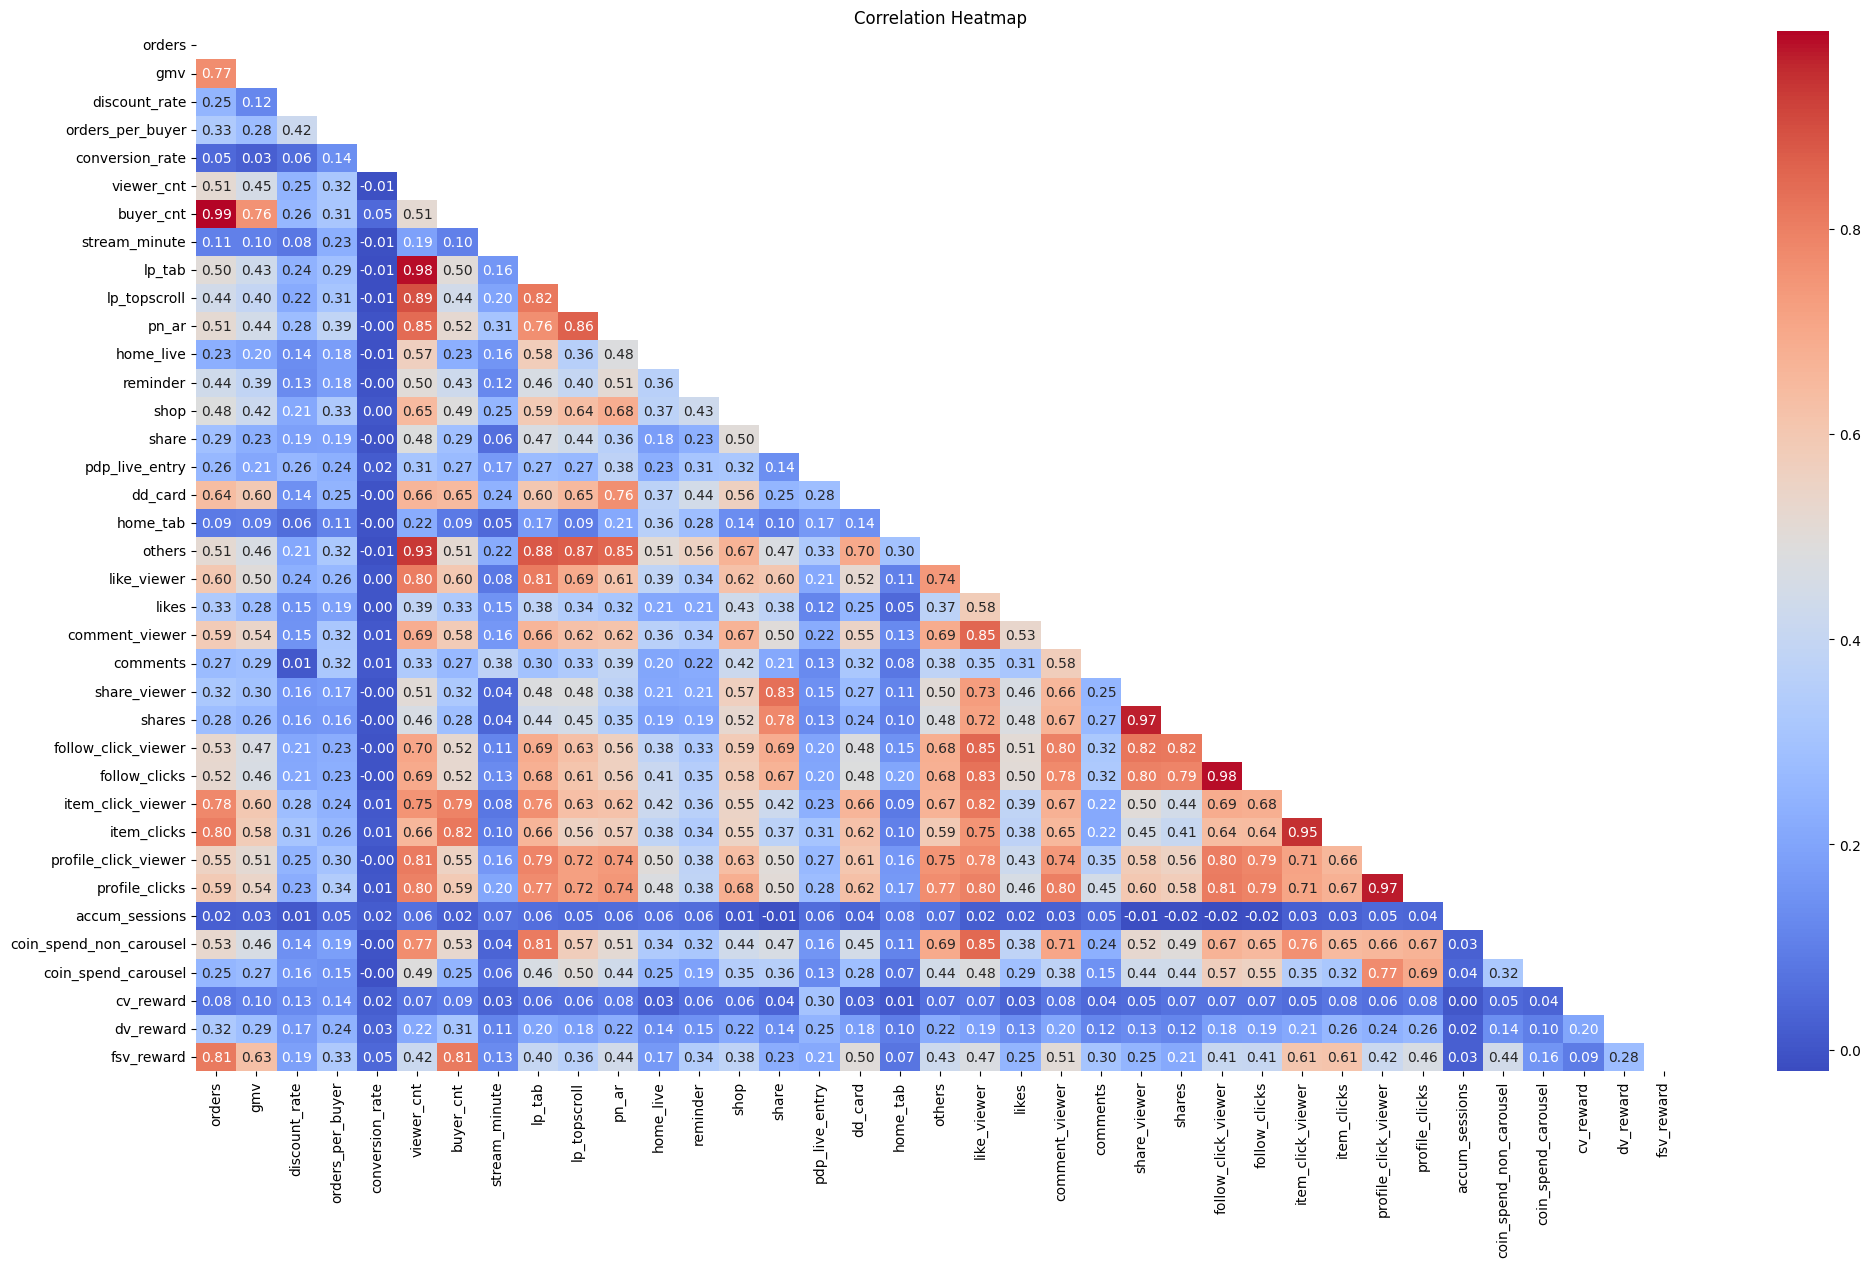

In [ ]:
corr_df = is_lc_df[['orders',
                    'gmv',
                    'discount_rate',
                    'orders_per_buyer',
                    'conversion_rate',
                    'viewer_cnt',
                    'buyer_cnt',
                    'stream_minute',
                    # source of viewers
                    'lp_tab',
                    'lp_topscroll',
                    'pn_ar',
                    'home_live',
                    'reminder',
                    'shop',
                    'share',
                    'pdp_live_entry',
                    'dd_card',
                    'home_tab',
                    'others',
                    # functions
                    'like_viewer',
                    'likes',
                    'comment_viewer',
                    'comments',
                    'share_viewer',
                    'shares',
                    'follow_click_viewer',
                    'follow_clicks',
                    'item_click_viewer',
                    'item_clicks',
                    'profile_click_viewer',
                    'profile_clicks',
                    'accum_sessions',
                    'coin_spend_non_carousel',
                    'coin_spend_carousel',
                    'cv_reward',
                    'dv_reward',
                    'fsv_reward']]

correlation_matrix = corr_df.corr()

plt.figure(figsize = (24, 13.5))
sns.heatmap(correlation_matrix,
            annot = True,
            cmap = 'coolwarm',
            fmt = '.2f',
            mask = np.triu(np.ones_like(correlation_matrix, dtype = bool)),
            annot_kws = {'size': 10})

plt.title('Correlation Heatmap')
plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
source_col = ['lp_tab', 'lp_topscroll','pn_ar',
               'home_live', 'reminder', 'shop',
               'share', 'pdp_live_entry', 'dd_card',
               'home_tab', 'others']

function_col = ['like_viewer', 'likes', 'comment_viewer',
                 'comments', 'share_viewer', 'shares',
                 'follow_click_viewer', 'follow_clicks', 'item_click_viewer',
                 'item_clicks', 'profile_click_viewer', 'profile_clicks',
                 'accum_sessions', 'coin_spend_non_carousel', 'coin_spend_carousel',
                 'cv_reward', 'dv_reward', 'fsv_reward']

df[source_col]
df[function_col]

,lp_tab,lp_topscroll,pn_ar,home_live,reminder,shop,share,pdp_live_entry,dd_card,home_tab,others
0,16,17,5,2,0,0,1,0,2,0,6
1,2,4,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
241850,19,7,6,1,2,1,0,0,0,0,6
241851,2,0,0,0,0,0,1,0,0,0,15
241852,42,25,20,7,0,0,0,0,4,1,20
241853,54,17,10,3,0,0,1,1,0,1,19


,like_viewer,likes,comment_viewer,comments,share_viewer,shares,follow_click_viewer,follow_clicks,item_click_viewer,item_clicks,profile_click_viewer,profile_clicks,accum_sessions,coin_spend_non_carousel,coin_spend_carousel,cv_reward,dv_reward,fsv_reward
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241850,0,0,1,1,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0
241851,0,0,1,8,0,0,0,0,0,0,0,0,4,0,0,0.0,0.0,0.0
241852,0,0,0,0,0,0,0,0,0,0,1,1,5,0,0,0.0,0.0,0.0
241853,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0.0,0.0,0.0


## **4-3. Random Forest**

In [ ]:
%%time
x = is_lc_df[['orders_per_buyer',
              'conversion_rate',
              'viewer_cnt',
              'stream_minute',
              'like_viewer',
              'likes',
              'comment_viewer',
              'comments',
              'share_viewer',
              'shares',
              'follow_click_viewer',
              'follow_clicks',
              'item_click_viewer',
              'item_clicks',
              'profile_click_viewer',
              'profile_clicks',
              'accum_sessions',
              'coin_spend_non_carousel',
              'coin_spend_carousel',
              'cv_reward',
              'dv_reward',
              'fsv_reward']]

y = is_lc_df['cum_orders_per_accum_session']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting cum_orders_per_accum_session')

fig.show()

Training the model...


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]

Making predictions...
Mean Squared Error: 13.671414058933312


CPU times: user 34.6 s, sys: 45.5 ms, total: 34.6 s
Wall time: 35.6 s


In [ ]:
feature_importance_df

,Feature,Importance
4,buyer_cnt,0.837286
13,item_click_viewer,0.035900
14,item_clicks,0.028087
22,fsv_reward,0.016434
2,viewer_cnt,0.009513
3,stream_minute,0.007780
7,comment_viewer,0.007339
1,conversion_rate,0.007203
8,comments,0.005705
17,accum_sessions,0.005152


In [ ]:
%%time
x = is_lc_df[['orders_per_buyer',
              'conversion_rate',
              'stream_minute',
              'buyer_cnt',
              'like_viewer',
              'likes',
              'comment_viewer',
              'comments',
              'share_viewer',
              'shares',
              'follow_click_viewer',
              'follow_clicks',
              'item_click_viewer',
              'item_clicks',
              'profile_click_viewer',
              'profile_clicks',
              'accum_sessions',
              'coin_spend_non_carousel',
              'coin_spend_carousel',
              'cv_reward',
              'dv_reward',
              'fsv_reward']]

y = is_lc_df['viewer_cnt']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting viewer_cnt')

fig.show()

Training the model...


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

Making predictions...
Mean Squared Error: 1361978.2763187801


CPU times: user 28.9 s, sys: 39.4 ms, total: 28.9 s
Wall time: 29 s


In [ ]:
feature_importance_df

,Feature,Importance
4,like_viewer,0.538424
17,coin_spend_non_carousel,0.124161
14,profile_click_viewer,0.066006
12,item_click_viewer,0.058584
10,follow_click_viewer,0.056115
15,profile_clicks,0.026913
11,follow_clicks,0.017629
13,item_clicks,0.016815
2,stream_minute,0.014660
1,conversion_rate,0.012222


In [ ]:
%%time
x = is_lc_df[['orders_per_buyer',
              'viewer_cnt',
              'stream_minute',
              'buyer_cnt',
              'like_viewer',
              'likes',
              'comment_viewer',
              'comments',
              'share_viewer',
              'shares',
              'follow_click_viewer',
              'follow_clicks',
              'item_click_viewer',
              'item_clicks',
              'profile_click_viewer',
              'profile_clicks',
              'accum_sessions',
              'coin_spend_non_carousel',
              'coin_spend_carousel',
              'cv_reward',
              'dv_reward',
              'fsv_reward']]

y = is_lc_df['conversion_rate']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting conversion_rate')

fig.show()

Training the model...


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

Making predictions...
Mean Squared Error: 3.3924095082721492e-06


CPU times: user 14.1 s, sys: 39.9 ms, total: 14.2 s
Wall time: 16 s


In [ ]:
feature_importance_df

,Feature,Importance
1,viewer_cnt,0.619077
3,buyer_cnt,0.134235
21,fsv_reward,0.124085
0,orders_per_buyer,0.115368
20,dv_reward,0.001386
2,stream_minute,0.001014
12,item_click_viewer,0.000948
4,like_viewer,0.000796
13,item_clicks,0.000474
5,likes,0.000449


In [ ]:
%%time
x = is_lc_df[['viewer_cnt',
              'conversion_rate',
              'stream_minute',
              'buyer_cnt',
              'like_viewer',
              'likes',
              'comment_viewer',
              'comments',
              'share_viewer',
              'shares',
              'follow_click_viewer',
              'follow_clicks',
              'item_click_viewer',
              'item_clicks',
              'profile_click_viewer',
              'profile_clicks',
              'accum_sessions',
              'coin_spend_non_carousel',
              'coin_spend_carousel',
              'cv_reward',
              'dv_reward',
              'fsv_reward']]

y = is_lc_df['orders_per_buyer']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting orders_per_buyer')

fig.show()

Training the model...


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

Making predictions...
Mean Squared Error: 0.07355992590014214


CPU times: user 10.9 s, sys: 26 ms, total: 10.9 s
Wall time: 11 s


In [ ]:
feature_importance_df

,Feature,Importance
1,conversion_rate,0.456511
3,buyer_cnt,0.416365
21,fsv_reward,0.013497
0,viewer_cnt,0.010406
2,stream_minute,0.009062
17,coin_spend_non_carousel,0.009036
7,comments,0.008801
4,like_viewer,0.008176
5,likes,0.007778
14,profile_click_viewer,0.007464


In [ ]:
%%time
x = no_lc_df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]

y = no_lc_df['cum_orders_per_accum_session']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting cum_orders_per_accum_session')

fig.show()

In [ ]:
feature_importance_df

In [ ]:
%%time
x = is_lc_df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]

y = is_lc_df['viewer_cnt']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting viewer_cnt')

fig.show()

In [ ]:
feature_importance_df

In [ ]:
%%time
x = no_lc_df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]

y = no_lc_df['viewer_cnt']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Initialize RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators = 100,
                                     random_state = 42)  # can adjust the number of trees (n_estimators) as needed

# Train the model
tqdm.write("Training the model...")
for _ in tqdm(range(10)):
    rf_regressor.fit(x_train, y_train)

# Predict on the test set
tqdm.write("Making predictions...")
y_pred = rf_regressor.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display feature importance
feature_importances = rf_regressor.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

# Visualize feature importance
fig = px.bar(feature_importance_df,
             x = 'Importance',
             y = 'Feature',
             orientation = 'h',
             labels = {'Importance': 'Importance', 'Feature': 'Feature'},
             title = 'Feature Importance in Random Forest Regressor on Predicting viewer_cnt')

fig.show()

In [ ]:
df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'viewer_cnt',
        'discount_rate',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]


,coin_spend_non_carousel,coin_spend_carousel,viewer_cnt,discount_rate,cv_reward,dv_reward,fsv_reward
0,0,0,50,NaN,0.0,0.0,0.0
1,0,0,9,NaN,0.0,0.0,0.0
2,0,0,0,NaN,0.0,0.0,0.0
3,0,0,1,NaN,0.0,0.0,0.0
4,0,0,3,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...
241850,0,0,46,NaN,0.0,0.0,0.0
241851,0,0,18,NaN,0.0,0.0,0.0
241852,0,0,127,NaN,0.0,0.0,0.0
241853,0,0,111,NaN,0.0,0.0,0.0


In [ ]:
feature_importance_df

## **4-4. Linear Regression**

In [ ]:
X = is_lc_df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'viewer_cnt',
        'discount_rate',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]

y = is_lc_df['cum_orders_per_accum_session']

best_r2 = 0
best_train_r2 = 0
best_test_r2 = 0
best_train_size = 0

for train_size in tqdm(range(1, len(X))):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size / len(X), random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    if test_r2 > best_r2:
        best_r2 = test_r2
        best_train_r2 = train_r2
        best_test_r2 = test_r2
        best_train_size = train_size / len(X)
        best_model = model

coefficients = best_model.coef_
constant = best_model.intercept_

equation = "y = "
for i, coef in enumerate(coefficients):
    equation += "{}x{} + ".format(coef, i + 1)
equation += str(constant)

print("Best R^2:", best_r2)
print("Corresponding train R^2:", best_train_r2)
print("Corresponding test R^2:", best_test_r2)
print("Best train size:", best_train_size)
print("Equation:", equation)

  0%|          | 0/42199 [00:00<?, ?it/s]

LinearRegression()

  0%|          | 0/42199 [00:00<?, ?it/s]


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
X = is_lc_df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]

y = is_lc_df['viewer_cnt']

best_r2 = 0
best_train_r2 = 0
best_test_r2 = 0
best_train_size = 0

for train_size in tqdm(range(1, len(X))):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size / len(X), random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    if test_r2 > best_r2:
        best_r2 = test_r2
        best_train_r2 = train_r2
        best_test_r2 = test_r2
        best_train_size = train_size / len(X)
        best_model = model

coefficients = best_model.coef_
constant = best_model.intercept_

equation = "y = "
for i, coef in enumerate(coefficients):
    equation += "{}x{} + ".format(coef, i + 1)
equation += str(constant)

print("Best R^2:", best_r2)
print("Corresponding train R^2:", best_train_r2)
print("Corresponding test R^2:", best_test_r2)
print("Best train size:", best_train_size)
print("Equation:", equation)

In [ ]:
InteractiveShell.ast_node_interactivity = 'last'

In [ ]:
sample_df = no_lc_df.sample(len(is_lc_df))

X = sample_df[['coin_spend_non_carousel',
        'coin_spend_carousel',
        'cv_reward',
        'dv_reward',
        'fsv_reward']]

y = sample_df['cum_orders_per_accum_session']

best_r2 = 0
best_train_r2 = 0
best_test_r2 = 0
best_train_size = 0

for train_size in tqdm(range(1, len(X))):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size / len(X), random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    if test_r2 > best_r2:
        best_r2 = test_r2
        best_train_r2 = train_r2
        best_test_r2 = test_r2
        best_train_size = train_size / len(X)
        best_model = model

coefficients = best_model.coef_
constant = best_model.intercept_

equation = "y = "
for i, coef in enumerate(coefficients):
    equation += "{}x{} + ".format(coef, i + 1)
equation += str(constant)

print("Best R^2:", best_r2)
print("Corresponding train R^2:", best_train_r2)
print("Corresponding test R^2:", best_test_r2)
print("Best train size:", best_train_size)
print("Equation:", equation)

  0%|          | 0/3899 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

100%|█████████▉| 3895/3899 [01:07<00:00, 45.29it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

100%|██████████| 3899/3899 [01:07<00:00, 57.92it/s]

Best R^2: 0.9267319596654011
Corresponding train R^2: 0.29654685609163667
Corresponding test R^2: 0.9267319596654011
Best train size: 0.9912820512820513
Equation: y = 1.4178253628979295e-05x1 + -2.4800165520369817e-05x2 + 0.001047438704171688x3 + -0.00018128565519570582x4 + 0.0031469951244823646x5 + 1.2462313945102519
